Known:
- calcualted effective area is same as paper
- calculated gamma is same as paper for wavelength 1550nm
- exact same source is used for the linear refractive index

Issue:
- calculated GVD and spectrum doesn't match at long wavelength side -> need more step/ resolution ?? Incorrect neff?? 

Note:
- Tried higher resolution - no improvement
- fix refractive index for high wavelength of SI3N4
- check mode profile in long wavelength side

https://iopscience.iop.org/article/10.1088/1555-6611/aaf63d 
H Ahmad et al 2019 Laser Phys. 29 025301

First, construct the geometry of the waveguide and create a mesh. Then generate the effective refractive index and effective mode area of the waveguide using femwell.

<skfem MeshTri1 object>
  Number of elements: 44046
  Number of vertices: 22184
  Number of nodes: 22184
  Named subdomains [# elements]: core [7908], lower_cladding [15392], air [20746], gmsh:bounding_entities [18]
  Named boundaries [# facets]: core___lower_cladding [150], core___air [190], lower_cladding___air [66]


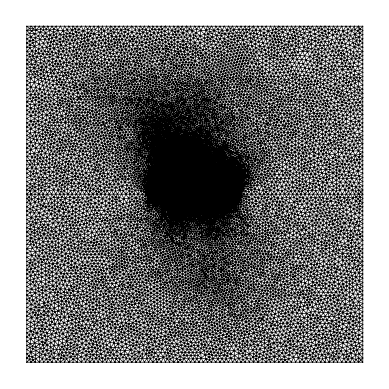

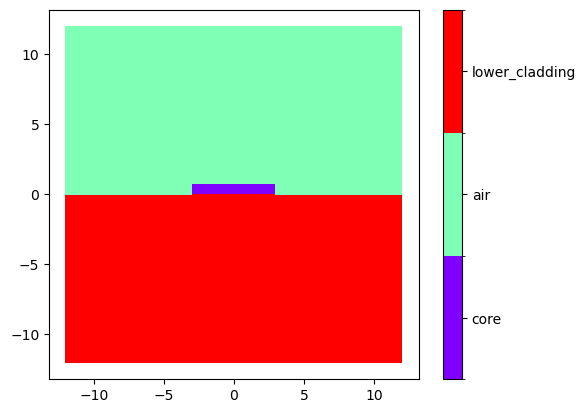

start


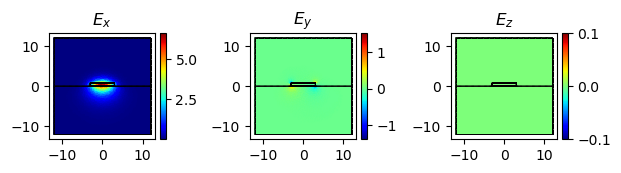

neff is (1.387495050215018+0j), aeff is 13.811217906001197


In [1]:
from femwell.maxwell.waveguide import compute_modes
from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.visualization import plot_domains
from skfem.io import from_meshio
import shapely
import matplotlib.pyplot as plt
from refractive_index import n_MgF2, n_Si3N4, n_Air
from collections import OrderedDict
from femwell.mesh import mesh_from_OrderedDict
import numpy as np

# waveguide parameters
width = 6  # um
height = 0.8  # um

n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

wavelength_range = [310, 5100]
wavelegnth_step = 70  #  steps

n_core = n_Si3N4
n_lower_cladding = lambda w: n_MgF2(w, ray="o") # TODO: check effect of this line
n_air = n_Air
box_length = 12
# Construct waveguide geometry
core = shapely.geometry.box(-width / 2, 0, +width / 2, height)
lower_cladding = shapely.geometry.box(-box_length, -box_length, box_length, 0)
air = shapely.geometry.box(-box_length, 0, box_length, box_length)
polygons = OrderedDict(
    core=core,
    lower_cladding=lower_cladding,
    air= air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.04, "distance": 0.1},
                   lower_cladding={"resolution": 0.3, "distance": 0.2},
                   air={"resolution": 0.3, "distance": 0.2})

n_dict = {"core": n_core, "lower_cladding": n_lower_cladding, "air": n_air}

# Calculate dispersion and gamma
mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions))
print(mesh)
mesh.draw().show()
plot_domains(mesh)
plt.show()

print("start")
# Calculate dispersion and gamma
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.linspace(wavelength_range[0], wavelength_range[1], wavelegnth_step)

wavelength = 5000 * 1e-3
for subdomain, n in n_dict.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.n_eff))
mode = modes_sorted[0]
mode.show(mode.E.real, direction ="x")

print(f"neff is {mode.n_eff}, aeff is {mode.calculate_effective_area()}")



Plot the effective mode area and gamma to see if we can reproduce the result in the paper.

0.32013316296564315


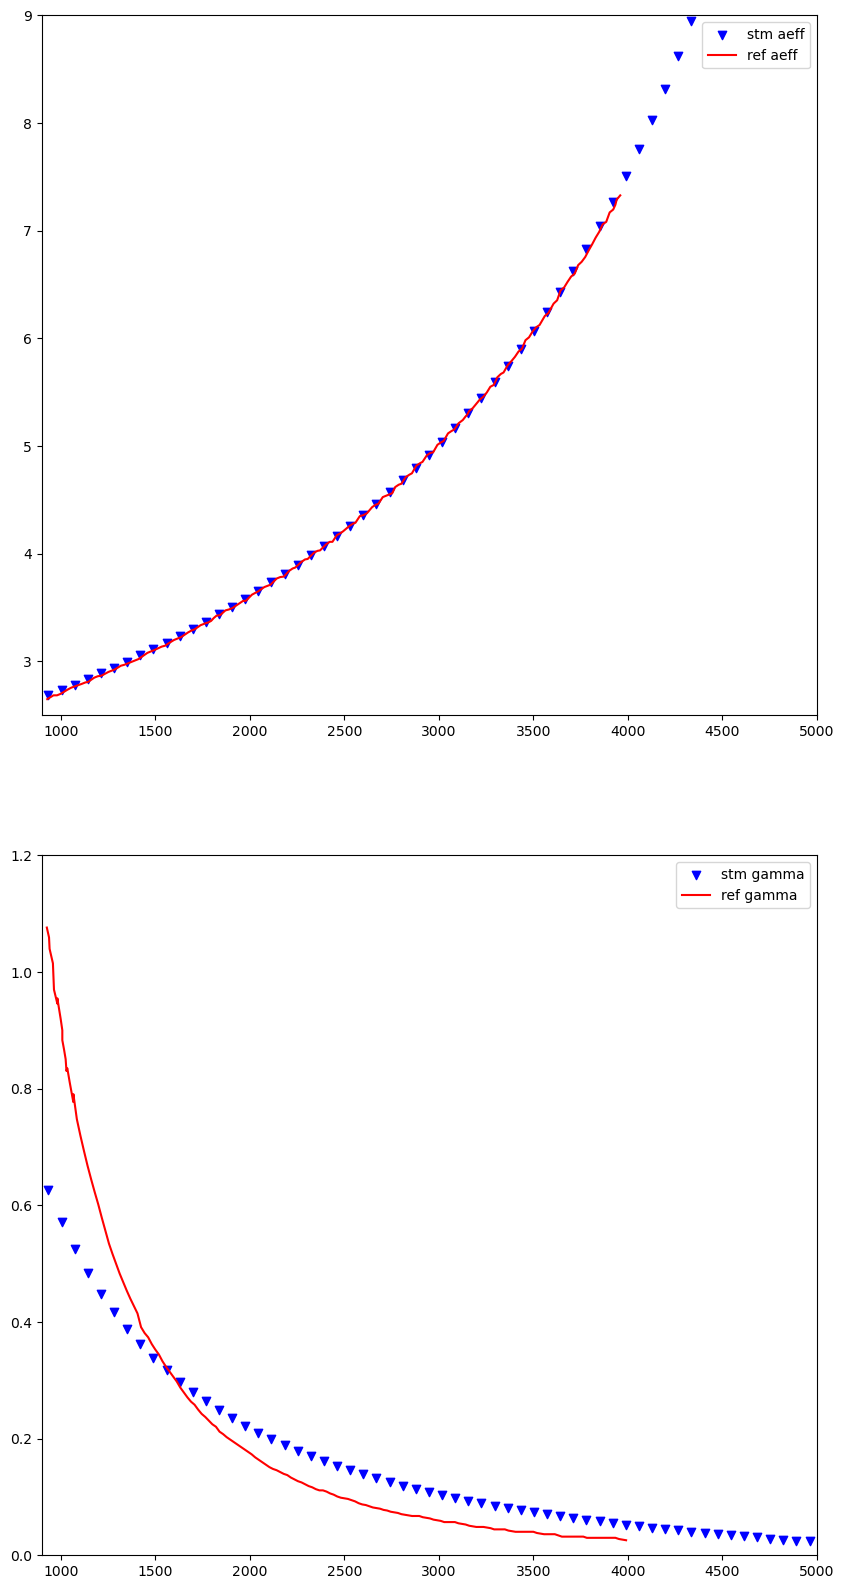

Gamma is 0.32000591757172686/W/m at pump wavelength(1.55um), and the value from paper is 0.32/W/m


In [6]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

data = np.load("data_h_0.8_w_6_no.npz")
wls = data['wls']
c_mks = 299792458.0
n2 = 2.5e-19
pulseWL = 1550
aeff_list = data['aeff_list']


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma


gamma_list = list(map(gamma_function, wls))
gamma_interp = scipy.interpolate.interp1d(wls, gamma_list)
print(gamma_interp(1550))

# Read reference aeff and gamma value from the file
aeff_x, aeff_y = list(np.split(pd.read_csv(
    "../reference_data/aeff.csv", dtype=np.float64
).values, 2, axis=1))

g_x, g_y = list(np.split(pd.read_csv(
    "../reference_data/gamma.csv", dtype=np.float64
).values, 2, axis=1))

# Plot aeff graph
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))
ax1.scatter(wls, aeff_list, marker="v", c="b", label="stm aeff")
ax1.plot(aeff_x, aeff_y, c="r", label="ref aeff")
ax1.legend()

ax1.set_xlim(900, 5000)
ax1.set_ylim(2.5, 9)

# Plot gamma graph
ax2.scatter(wls, gamma_list, marker="v", c="b", label="stm gamma")
ax2.plot(g_x, g_y, c="r", label="ref gamma")
ax2.legend()

ax2.set_xlim(900, 5000)
ax2.set_ylim(0, 1.2)
plt.show()

print(f"Gamma is {gamma_function(1550)}/W/m at pump wavelength(1.55um), and the value from paper is 0.32/W/m")

Try to reproduce to GVD vs wavelength graph by fitting refractive effective index and wavelength in a curve then take derivative. 

1.9490726408462087


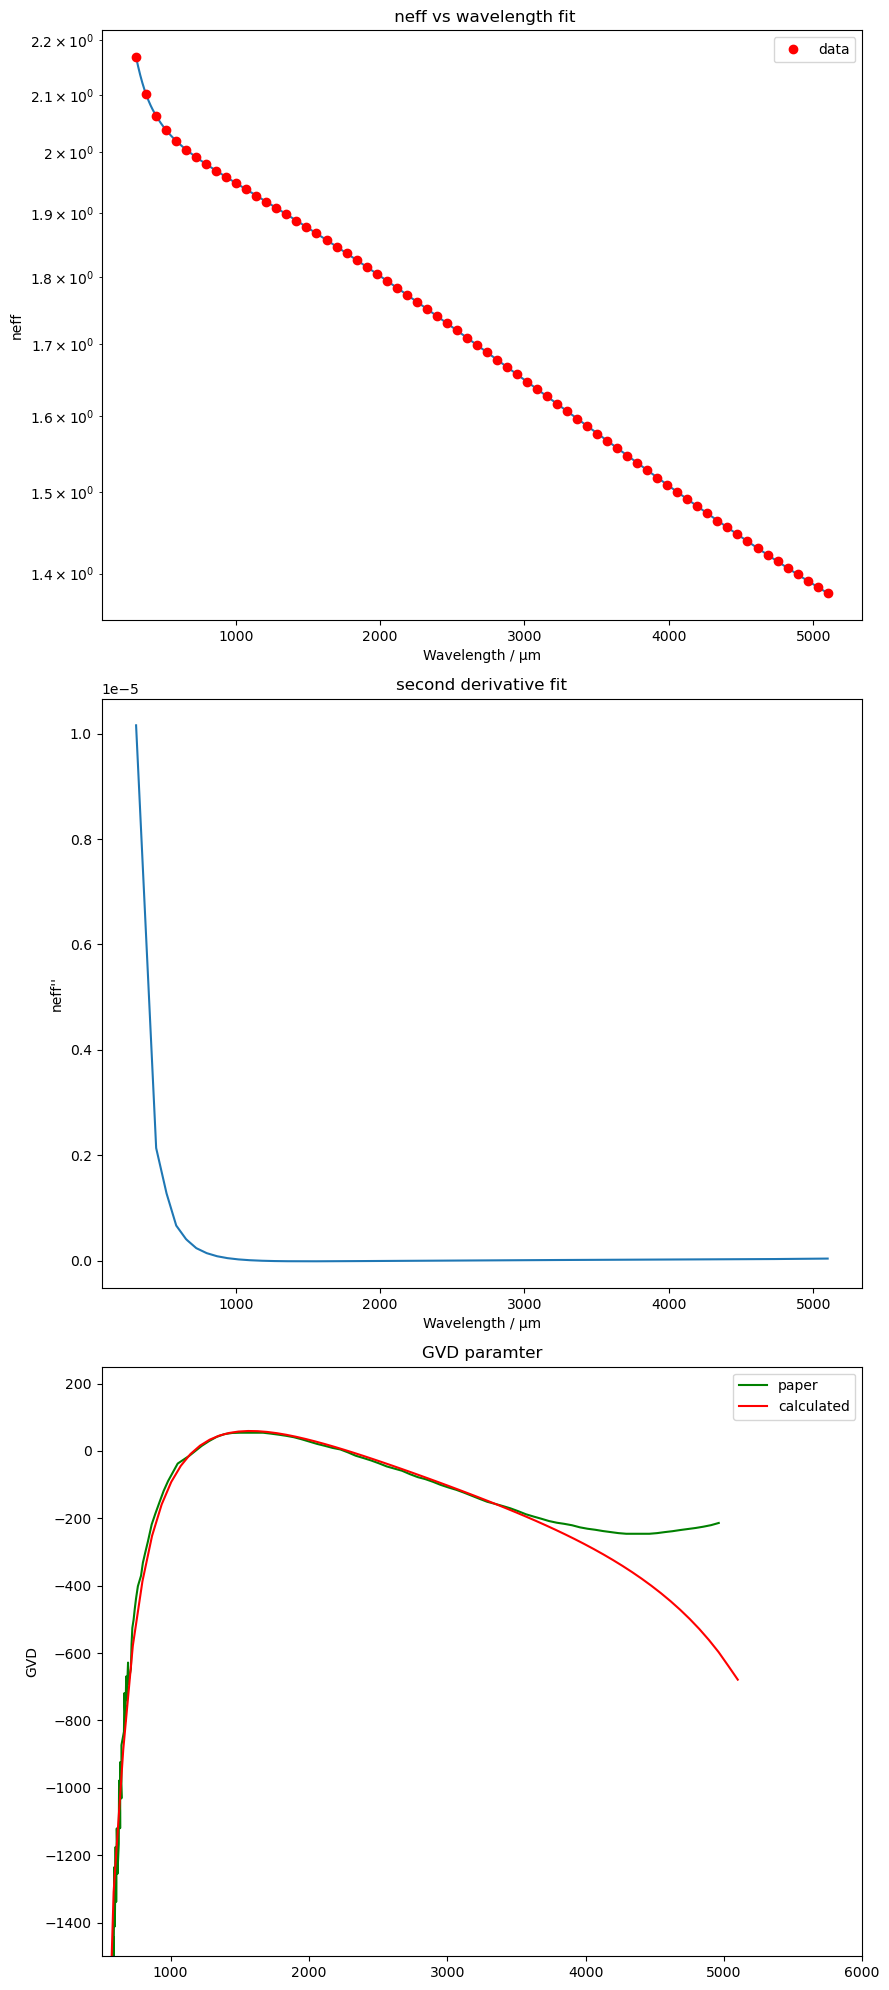

"\nplt.semilogy(wls,neff_list,'ro',label = 'data')\nx_range = np.linspace(wls[0],wls[-1],1000)\nplt.semilogy(x_range,y_spl(x_range))\n\nplt.legend()\nplt.tight_layout()\nplt.show()\n\n"

In [7]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
import pandas as pd
from scipy.constants import speed_of_light

width = 6  # um
height = 0.8  # um

data = np.load(f"data_h_{height}_w_{width}_no.npz")
neff_list = data['neff_list']
wls = data['wls']

fig, axs = plt.subplots(3, 1, figsize=(9, 20))

y_spl = UnivariateSpline(wls, neff_list, s=0, k=3)
x_range = np.linspace(wls[0], wls[-1], 1000)
print(y_spl(1000))

axs[0].set_xlabel("Wavelength / µm")
axs[0].set_ylabel("neff")
axs[0].set_title(" neff vs wavelength fit")
axs[0].semilogy(x_range, y_spl(x_range))
axs[0].semilogy(wls, neff_list, 'ro', label='data')
axs[0].legend()

y_spl_2d = y_spl.derivative(n=2)
axs[1].set_xlabel("Wavelength / µm")
axs[1].set_ylabel("neff''")
axs[1].set_title("second derivative fit")
axs[1].plot(x_range, y_spl_2d(x_range))

ref_gvd = pd.read_csv("../reference_data/GVD.csv", dtype=np.float64)
ref_gvd_x, ref_gvd_y = np.split(ref_gvd.values, 2, axis=1)
axs[2].plot(ref_gvd_x, ref_gvd_y, c="green", label="paper")

GVD = (-wls / (2.99792e-7) * y_spl_2d(wls))
axs[2].plot(wls, GVD, label="calculated", c="red")

axs[2].set_ylabel("GVD")
axs[2].set_ylim(-1500, 250)
axs[2].set_xlim(500, 6000)
axs[2].set_title("GVD paramter")
axs[2].legend()

plt.tight_layout()
plt.show()

'''
plt.semilogy(wls,neff_list,'ro',label = 'data')
x_range = np.linspace(wls[0],wls[-1],1000)
plt.semilogy(x_range,y_spl(x_range))

plt.legend()
plt.tight_layout()
plt.show()

'''


Use laserfun to reproduce the spectrum of Fig 5d)


   0.3% - 3.344e-05 m - 0.0 seconds
   0.7% - 6.689e-05 m - 0.0 seconds
   1.0% - 1.003e-04 m - 0.1 seconds
   1.3% - 1.338e-04 m - 0.1 seconds
   1.7% - 1.672e-04 m - 0.1 seconds
   2.0% - 2.007e-04 m - 0.1 seconds
   2.3% - 2.341e-04 m - 0.1 seconds
   2.7% - 2.676e-04 m - 0.1 seconds
   3.0% - 3.010e-04 m - 0.1 seconds
   3.3% - 3.344e-04 m - 0.1 seconds
   3.7% - 3.679e-04 m - 0.1 seconds
   4.0% - 4.013e-04 m - 0.1 seconds
   4.3% - 4.348e-04 m - 0.1 seconds
   4.7% - 4.682e-04 m - 0.1 seconds
   5.0% - 5.017e-04 m - 0.1 seconds
   5.4% - 5.351e-04 m - 0.1 seconds
   5.7% - 5.686e-04 m - 0.1 seconds
   6.0% - 6.020e-04 m - 0.1 seconds
   6.4% - 6.355e-04 m - 0.1 seconds
   6.7% - 6.689e-04 m - 0.1 seconds
   7.0% - 7.023e-04 m - 0.1 seconds
   7.4% - 7.358e-04 m - 0.1 seconds
   7.7% - 7.692e-04 m - 0.1 seconds
   8.0% - 8.027e-04 m - 0.1 seconds
   8.4% - 8.361e-04 m - 0.1 seconds
   8.7% - 8.696e-04 m - 0.1 seconds
   9.0% - 9.030e-04 m - 0.1 seconds
   9.4% - 9.365e-04 m - 0.1 

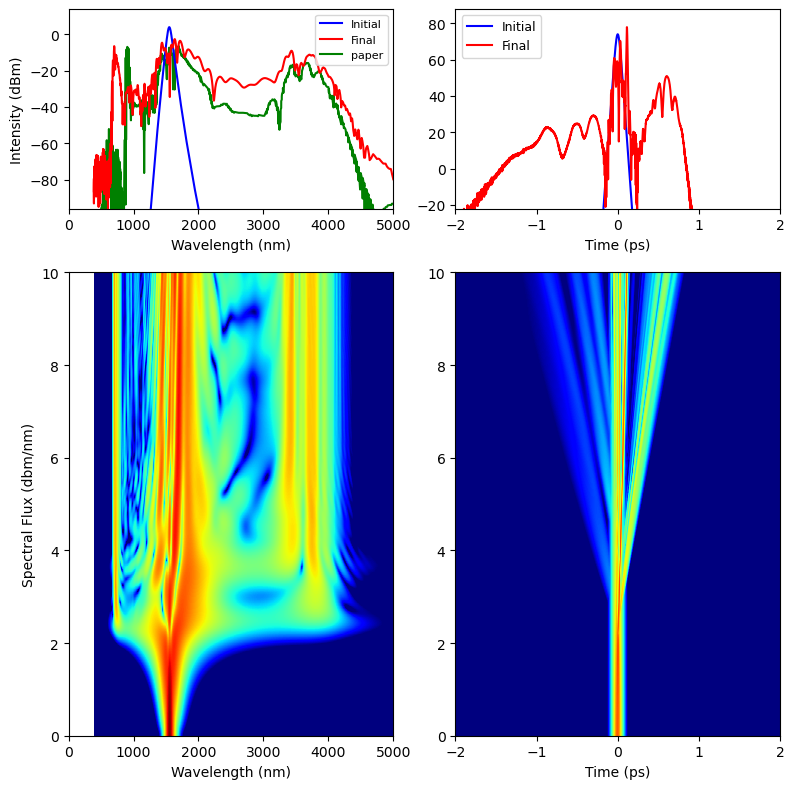

In [8]:

import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

# pulse parameters
FWHM = 50 * 1e-3  # pulse duration (ps)
pulseWL = 1550  # pulse central wavelength (nm)

power = 5000  # W
GDD = False  # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion

# simulation parameters
Window = 4  # simulation window (ps)
Steps = 300  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4 # absolute error
Raman = False  # Enable Raman effect?
Steep = True  # Enable self steepening?

# ----------- Build Waveguide -----------
n2 = 2.5e-19  # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.7  # loss (dB/cm)

data = np.load("data_h_0.8_w_6_no.npz")
wls = data['wls']
neff_list = data['neff_list']
aeff_list = data['aeff_list']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma


# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=False, wav=wls, power=power, RI=neff_list, GDD=GDD, TOD=TOD, FOD=FOD,
             npts=Points)

# create the waveguide
f = lf.Fiber(10 * 1e-3, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(pulseWL), loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
###
ref_fig5d = pd.read_csv(
    "../reference_data/fig5d.csv", dtype=np.float64
)

fig, axes = results.plot(wavelength=True, show=False, tlim=(-2, 2), flim=(0, 6000))
ref_fig5d_x, ref_fig5d_y = np.split(ref_fig5d.values, 2, axis=1)

axes[0][0].plot(ref_fig5d_x, ref_fig5d_y, c="green", label="paper", zorder=0)
axes[0][0].legend(loc="upper right", fontsize=8)

axes[1][0].set_xlim(0, 5000)
plt.set_cmap('jet')
plt.show()
